# Plotovani namerenych foton-korelacnich histogramu

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# data import
#import pandas as pd
import numpy as np

#data_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_delim.txt", sep="\t").values
#voltages_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_voltages.txt", sep="\t").values

data_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")
data_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")
data_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_delim.txt", delimiter="\t")[:,:2]
voltages_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_voltages.txt", delimiter="\t")

fotkor_bezcond=np.concatenate( (data_bezcond_p1 ,data_bezcond_p2, data_bezcond_p3) ,axis=1)
voltages_bezcond=np.concatenate( (voltages_bezcond_p1 ,voltages_bezcond_p2, voltages_bezcond_p3) ,axis=0)

# pomocne promene
fotkor_shape = np.shape(fotkor_bezcond)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res

#---------- odecet pozadi
background_photocounts = 400 # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
bg_ph_sum = background_photocounts * t_measure  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio = fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin = bg_ph_sum/(fotkor_shape[0]-2 + last_bin_ratio)

fotkor_bezcond[:fotkor_shape[0]-2,:] = fotkor_bezcond[:fotkor_shape[0]-2,:] - bg_ph_per_bin 
fotkor_bezcond[fotkor_shape[0]-2,:] = fotkor_bezcond[fotkor_shape[0]-2,:] - bg_ph_per_bin * last_bin_ratio
# ------------------------------

plot dat

In [4]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

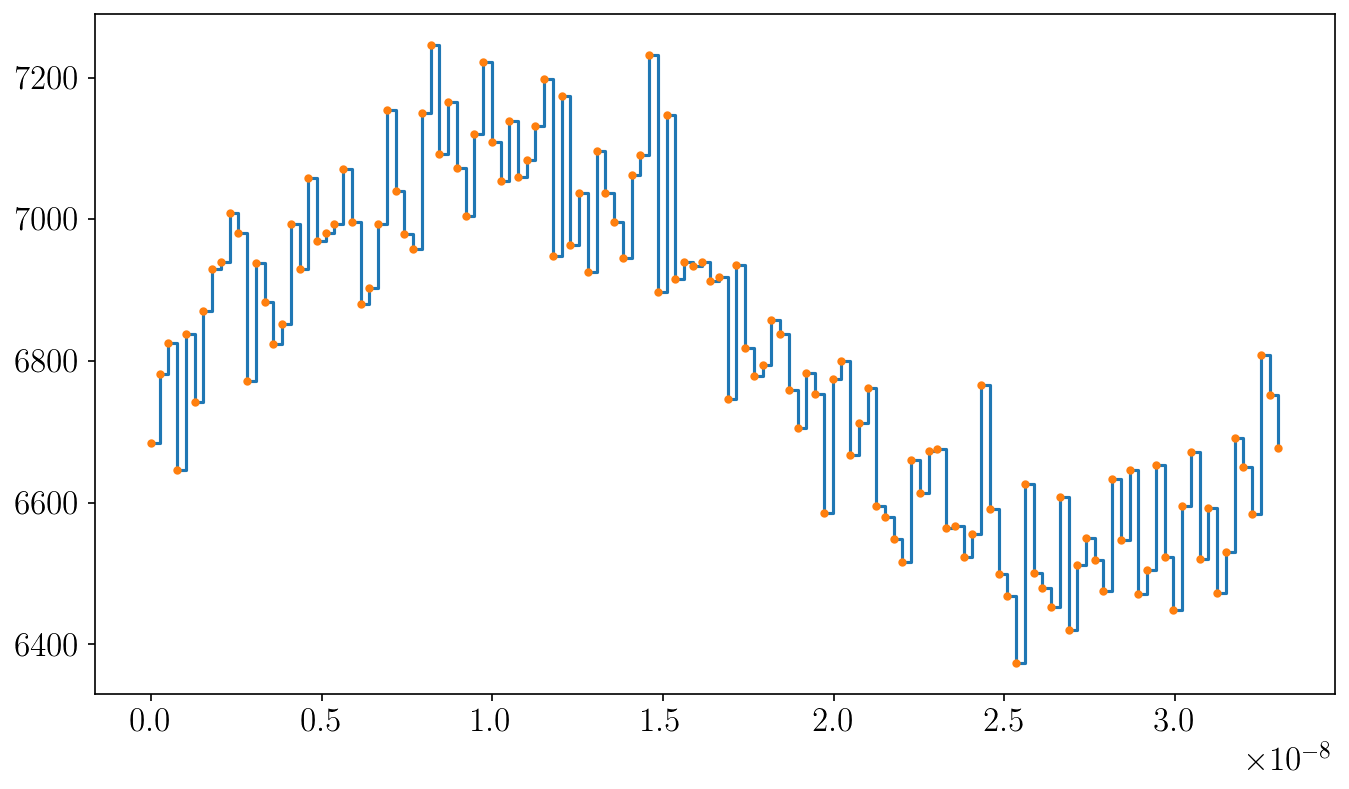

In [5]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
# plt.bar( t_scale[1:fotkor_shape[0]-2], fotkor_bezcond[1:fotkor_shape[0]-2,8], align='center')
# plt.hist(t_scale,bins=t_scale, weights=fotkor_bezcond[:,8], histtype='step');
plt.step(t_scale[0:fotkor_shape[0]-2], fotkor_bezcond[0:fotkor_shape[0]-2,8], where='post')
plt.plot(t_scale[0:fotkor_shape[0]-2], fotkor_bezcond[0:fotkor_shape[0]-2,8], '.')

Krasa!

In [6]:
# odhad periody triggeru
T_trig = ( fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9] )* t_res + t_scale[fotkor_shape[0]-2]

T_trig_sigma = t_res
# frekvence buzeni pasti

drive_freq = 1/T_trig
drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
Omega = 2*np.pi * drive_freq
Omega_sigma = 2*np.pi * drive_freq_sigma
drive_freq

30032035.976450287

Histogram take nafituju

In [7]:
# funkce vracejici residua
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

In [9]:
from scipy.optimize import least_squares

x0 = [fotkor_bezcond[:fotkor_shape[0]-2,8].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,8].max()
    -fotkor_bezcond[:fotkor_shape[0]-2,8].min() ), 1.5]

W_vec = 1/86.036575**2 * np.ones(fotkor_shape[0]-2)

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor_bezcond[:fotkor_shape[0]-2,8], t_res) , ftol=1e-10, xtol=1e-10)

#---- odhad nejistot parametru----
jac = fit.jac
C = np.linalg.inv( np.matmul( np.transpose(jac), np.matmul( np.diag(W_vec), jac ) ) )  # variancni-kovariancni matice
resid_sq = fit.fun**2   # residua na druhou
g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
#-------------------------------

x = fit.x
sigmas = np.sqrt( np.diagonal(C) )
DeltaS_S_ratio = (x[1]/x[0]  )

#---- faze fot-kor signalu
fot_phi = np.angle(DeltaS_S_ratio*np.exp(1j*x[2])) 

#---- sigma delta s ku s
S0 = fit.x[0]
DeltaS = fit.x[1]
Delta_S_S_ratio_sigma = (np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )

In [10]:
DeltaS_S_ratio

-0.042950395354774296

In [11]:
Delta_S_S_ratio_sigma

In [12]:
fot_phi

-1.8731115295656122

Vykresleni i s fitem a errorbarem

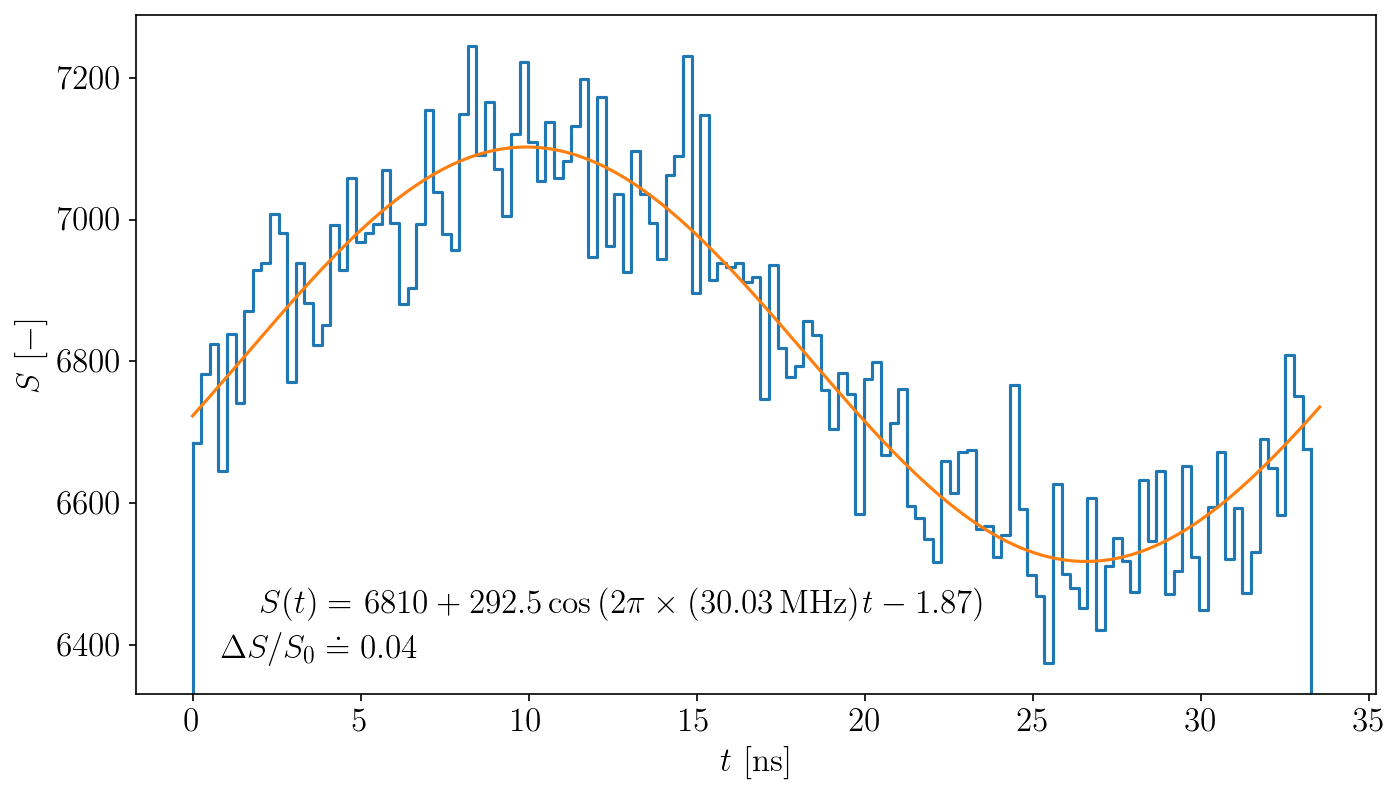

In [28]:
time_fit = np.linspace(0, t_scale.max(), 200)
fotkor_fit = fit_func(x, Omega, time_fit)

my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
# plt.bar( t_scale[1:fotkor_shape[0]-2], fotkor_bezcond[1:fotkor_shape[0]-2,8], align='center')
# plt.hist(t_scale,bins=t_scale, weights=fotkor_bezcond[:,8], histtype='step');
plt.step(t_scale[0:fotkor_shape[0]-2]*1e9, fotkor_bezcond[0:fotkor_shape[0]-2,8], where='post')
#plt.errorbar(t_scale[0:fotkor_shape[0]-2], fotkor_bezcond[0:fotkor_shape[0]-2,8],yerr=1/np.sqrt(W_vec), fmt='|')
# plt.plot(t_scale[0:fotkor_shape[0]-2], fotkor_bezcond[0:fotkor_shape[0]-2,8],'.')
plt.plot(time_fit*1e9, fotkor_fit)

# pridani zacatku a konce
ax = plt.gca()

plt.axvline(t_scale[0]*1e9, ymin=0, ymax=(fotkor_bezcond[0,8]-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]) )
plt.axhline(y=fotkor_bezcond[fotkor_shape[0]-3,8], xmin=(t_scale[fotkor_shape[0]-3]*1e9 - ax.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0]), 
                                                xmax=(t_scale[fotkor_shape[0]-2]*1e9 - ax.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0]))
plt.axvline(t_scale[fotkor_shape[0]-2]*1e9,ymin=0, ymax=(fotkor_bezcond[fotkor_shape[0]-3,8]-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]) )

#--------------

# popisky
plt.xlabel(r"$ t \,\, \rm [ns]$")
plt.ylabel(r"$ S \,\, [-]$")
text = r'$ S(t)  = \,\,$' + r'${:.0f} + {:.1f} \cos\left(2\pi \times ({:.2f}\,\rm MHz)\it t \rm - {:.2f}\right)$'.format(x[0], np.abs(x[1]),Omega*1e-6/(2*np.pi),-fot_phi)
plt.text(2, fotkor_bezcond[:,8].max()-800,text) 
text2 = r'$ \Delta S / S_0 \doteq {:.2f}$'.format(-x[1]/x[0])
plt.text(0.85, fotkor_bezcond[:,8].max()-870,text2)

#savefigure
#plt.savefig("/home/dan/diplomka_winfiles/Julia_vypocty_diplomka/julia_plots/fotkor_hist_example_v2.svg", bbox_inches="tight")

In [66]:
(fotkor_bezcond[fotkor_shape[0]-3,8]-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0])

0.36134278565471234

In [15]:
x[1]/x[0]

-0.042950395354774296

In [25]:
fot_phi+np.pi

1.268481124024181

In [20]:
np.real( np.abs(DeltaS_S_ratio) * np.exp(1j*fot_phi) )

-0.012787673194159039

In [23]:
DeltaS_S_ratio * np.cos(x[2])

-0.012787673194159034

In [24]:
x[2]

1.2684811240241811